# Генерация текста с помощью LSTM-сетей

Сеть способна выучить распределение символов в последовательностях


Датасет формируем проходясь окном по текстовому корпусу, задача сети - предсказывать следующий символ на основании нескольких предыдущих.
Данный подход можно улучшить, используя только отдельные предложения с паддингами.

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

### 0. Получение данных для обучения

Для обучения используется датасет российских новостей, который был сохранён в файл `text_corpus.parquet` со следующими параметрами:

In [12]:
# data.to_parquet("text_corpus.parquet", engine="pyarrow", compression="gzip", index=False)

In [4]:
data = pd.read_parquet("text_corpus.parquet", engine="pyarrow", )

In [5]:
len(data)

50000

In [6]:
# после обучения токенизатора можно уменьшить тренировочную выборку
# но нужно не забыть обновить переменную corpus
data = data.sample(10000)

### 1. Вспомогательные функции:


In [134]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [9]:
# весь текст одной "портянкой", чтобы заранее оценить, какие символы могут нам попадаться
# raw_text = " ".join(data.text)
# chars = sorted(list(set(raw_text)))
# chars

### 3. Предобработка и создание датасета

Для тренировки LSTM модели понадобится немного поработать с форматами

In [7]:
import re

In [8]:
corpus = " \n".join(data.text.to_list()).lower()
# Хочу отделить всю пунктуацию от слов пробелом
corpus = " ".join(re.findall(r"[\w']+|[.,!?;\n]", corpus))

In [42]:
total_words = 800
max_sequence_length = 80



#### 3.1 Токенизация BPE 

BPE токенизация посредством yttm эффективна, но потребуется поработать с файлом

In [10]:
import youtokentome as yttm

In [11]:
bpe_model_path = "bpe.yttm"

##### 3.2 Создаём токенизатор BPE и обучаем его

In [12]:
def create_bpe_tokenizer_from_scratch(corpus, train_data_path="yttm_train_data.txt"):
    with open(train_data_path, "w") as _file:
        _file.writelines(corpus)
    # Training model
    # (data, model, vocab_size, coverage, n_threads=-1, pad_id=0, unk_id=1, bos_id=2, eos_id=3)
    return yttm.BPE.train(data=train_data_path, vocab_size=total_words, model=bpe_model_path)

In [21]:
# Creating model
bpe = create_bpe_tokenizer_from_scratch(corpus)

In [12]:
# Loading model
bpe = yttm.BPE(model=bpe_model_path)

In [13]:
print(' '.join(bpe.vocab())[:300])

<PAD> <UNK> <BOS> <EOS> ▁ о е и а н т с р в л к п д м у я ы г з б , ь ч й . х ж ' ц ю ш ф щ э ъ ? ё ! ; _ ▁п ▁с ▁в ▁, ст ни ра ро но ре на ▁о ко то ▁. ▁и ▁по го не де те ли ва ▁м за ны ▁на ль ка ри та ле ла ▁д во ве ▁б ти ци ▁со ви ▁ч ки ло ▁у ▁за ▁' да ть ен ми ▁а ▁не ▁ко сс ▁пре ет ру ся ди ▁про н


In [102]:
# encode(self, 
#     sentences, 
#     output_type=yttm.OutputType.ID, 
#     bos=False, 
#     eos=False, 
#     reverse=False, 
#     dropout_prob=0)

In [14]:
encoded_corpus = np.array(bpe.encode(corpus))

# sequences = sequence[:-(len(sequence)%max_sequence_length)].reshape((len(sequence)//max_sequence_length, max_sequence_length))

In [33]:
from torch.utils.data import Dataset, DataLoader

In [96]:
class TextDataset(Dataset):
    def __init__(self, encoded_corpus, sequence_length=80):
        self.sequence_length = sequence_length
        self.n_samples = encoded_corpus.shape[0] - max_sequence_length - 1
        self.X = torch.from_numpy(encoded_corpus)
        
    def __getitem__(self, index):
        return self.X[index : index+self.sequence_length], self.X[index+self.sequence_length + 1].view((1))
    
    def __len__(self):
        return self.n_samples

In [97]:
dataset = TextDataset(encoded_corpus, sequence_length=max_sequence_length)


## 4. Модель

В качестве модели будет применяться LSTM сеть с двумя слоями LSTM

TODO
+ Gradient clipping
+ More layers?

In [98]:
class LSTMModel(nn.Module):
    def __init__(
            self, 
            input_size=max_sequence_length,
            num_classes=total_words,
            hidden_dim=64,
            num_layers=2,
            batch_size=128,
                ):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.2)
        
        # Embedding layer
        self.embedding = nn.Embedding(self.num_classes, self.hidden_dim, padding_idx=0)
        # Bi-LSTM
        # Forward and backward
        self.lstm_cell_forward = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
        self.lstm_cell_backward = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
        # LSTM layer
        self.lstm_cell = nn.LSTMCell(self.hidden_dim * 2, self.hidden_dim * 2)
        
#         self.lstm = nn.LSTM(
#             max_input_length,  # input_size – The number of expected features in the input x
#             hidden_dim, # hidden_size – The number of features in the hidden state h
#             num_layers, # num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
#             # bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
#             batch_first=True# batch_first – If True, then the input and output tensors are provided as (batch, seq, feature). Default: False
#             # dropout – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
#             bidirectional=True# bidirectional – If True, becomes a bidirectional LSTM. Default: False
#             # proj_size – If > 0, will use LSTM with projections of corresponding size. Default: 0
#         )
        
        self.linear = nn.Linear(self.hidden_dim * 2, self.num_classes)
        
        
    def forward(self, X):
        # Bi-LSTM
        # hs = [batch_size x hidden_size]
        # cs = [batch_size x hidden_size]
        hs_forward = torch.zeros(X.size(0), self.hidden_dim)
        cs_forward = torch.zeros(X.size(0), self.hidden_dim)
        hs_backward = torch.zeros(X.size(0), self.hidden_dim)
        cs_backward = torch.zeros(X.size(0), self.hidden_dim)

        # LSTM
        # hs = [batch_size x (hidden_size * 2)]
        # cs = [batch_size x (hidden_size * 2)]
        hs_lstm = torch.zeros(X.size(0), self.hidden_dim * 2)
        cs_lstm = torch.zeros(X.size(0), self.hidden_dim * 2)

        # Weights initialization
        torch.nn.init.kaiming_normal_(hs_forward)
        torch.nn.init.kaiming_normal_(cs_forward)
        torch.nn.init.kaiming_normal_(hs_backward)
        torch.nn.init.kaiming_normal_(cs_backward)
        torch.nn.init.kaiming_normal_(hs_lstm)
        torch.nn.init.kaiming_normal_(cs_lstm)

        # From idx to embedding
        out = self.embedding(X) 
#         print(f"Embedding output shape: {out.shape}") # [20,80,64]
        # Prepare the shape for LSTM Cells
        # out = out.view(self.sequence_len, X.size(0), -1)
        
        
        forward = []
        backward = []

        # Unfolding Bi-LSTM
        # Forward
        for i in range(self.input_size):
            hs_forward, cs_forward = self.lstm_cell_forward(out[:, i], (hs_forward, cs_forward))
            hs_forward = self.dropout(hs_forward)
            cs_forward = self.dropout(cs_forward)
            forward.append(hs_forward)

         # Backward
        for i in reversed(range(self.input_size)):
            hs_backward, cs_backward = self.lstm_cell_backward(out[:, i], (hs_backward, cs_backward))
            hs_backward = self.dropout(hs_backward)
            cs_backward = self.dropout(cs_backward)
            backward.append(hs_backward)
            
            
         # LSTM
        for fwd, bwd in zip(forward, backward):
            input_tensor = torch.cat((fwd, bwd), 1)
            hs_lstm, cs_lstm = self.lstm_cell(input_tensor, (hs_lstm, cs_lstm))

         # Last hidden state is passed through a linear layer
        out = self.linear(hs_lstm)
#         print(f"Linear input shape: {hs_lstm.shape}") [20, 128]
#         print(f"Linear output shape: {out.shape}") [20, 800]
        return out

In [140]:
learning_rate = 1e-4
num_epochs = 1
batch_size = 64
num_batches = int(len(dataset) / batch_size)
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
# Model initialization
model = LSTMModel(
            input_size=max_sequence_length,
            num_classes=total_words,
            hidden_dim=80,
            num_layers=2,
            batch_size=batch_size)

In [141]:
X, y = next(iter(dataloader))
y_ = model(X)

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
model.train()
loss_history = []
# Training pahse
for epoch in range(num_epochs):

    # Mini batches
    for i, (X, y) in tqdm(enumerate(dataloader), total=num_batches):
        # Feed the model
        y_pred = model(X)

        # Loss calculation
        loss = F.cross_entropy(y_pred, y.squeeze())
        loss_history.append(loss.item())
        
        # Clean gradients
        optimizer.zero_grad()

        # Calculate gradientes
        loss.backward()

        # Updated parameters
        optimizer.step()
        if not bool(i%1000):
            print("Epoch: %d ,  loss: %.5f " % (epoch, loss.item()))

  0%|          | 1/48120 [00:00<5:37:09,  2.38it/s]

Epoch: 0 ,  loss: 6.68214 


  2%|▏         | 1001/48120 [04:27<3:16:18,  4.00it/s]

Epoch: 0 ,  loss: 5.87584 


  4%|▍         | 2001/48120 [08:56<3:07:43,  4.09it/s]

Epoch: 0 ,  loss: 6.06271 


  6%|▌         | 3001/48120 [13:38<4:16:34,  2.93it/s] 

Epoch: 0 ,  loss: 5.91479 


  8%|▊         | 4001/48120 [19:51<6:01:29,  2.03it/s] 

Epoch: 0 ,  loss: 5.99771 


 10%|█         | 5001/48120 [27:23<4:06:41,  2.91it/s] 

Epoch: 0 ,  loss: 5.93749 


 12%|█▏        | 5726/48120 [36:00<3:47:29,  3.11it/s] 

In [110]:
# Save weights
torch.save(model.state_dict(), "./lstm__model.pt")

In [136]:
loss_history

[]

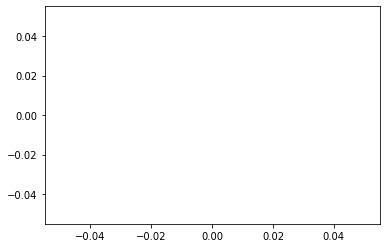

In [135]:
plt.plot(loss_history)

## 5. Инференс полученной модели

In [130]:
n_tokens = 400
# Set the model in evalulation mode
model.eval()

softmax = nn.Softmax(dim=1)

start = np.random.randint(0, len(dataset))
pattern, _ = dataset[start]
full_prediction = pattern.tolist()

print("Pattern:")
print(bpe.decode(full_prediction)[0], "\n")

for i in range(n_tokens):
    pattern = torch.tensor(full_prediction[:80]).view((1,-1))
    prediction = model(pattern)
    prediction = softmax(prediction)

    arg_max = torch.argmax(prediction).item()
    full_prediction.append(arg_max)

print("Prediction:")
print(bpe.decode(full_prediction)[0], "\n")

Pattern:
сообщил , что кремль начал планомерную работу по дискредитации навального . якобы решение спровоцировали фильм фбк он вам не димон и прошедшие по всей стране митинги , снизившие рейтинг премьер министра дмитрия 

Prediction:
сообщил , что кремль начал планомерную работу по дискредитации навального . якобы решение спровоцировали фильм фбк он вам не димон и прошедшие по всей стране митинги , снизившие рейтинг премьер министра дмитрия . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .